# Synthetic control

In this notebook, we simulate a panel dataset, then demonstrate the use of synthetic control to estimate causal effect.

## Data generating process

### Dynamic factor model

For the data-generating process, we employ a dynamic factor model.  In this framework, we posit the existence of some latent factors that drive the evolution of the outcomes across time.  This makes it a natural choice for simulating panel data: it allows us to generate data time series data for each unit in our sample, while letting each unit respond differently to the common underlying trends.  


Outcomes for each unit $i$ at time $t$ is specified as:
$$ 
\begin{align*}
Y_{it} = \sum_{k=1}^{K} \lambda_{ik} f_{kt} + \epsilon_{it}
\end{align*}
$$
where:
- $f_{kt}$ denote the time-varying latent factors. There are a total of $K$ latent factors.
- $\lambda_{ik}$ denote the unit-specific factor loadings.
- $\epsilon_{it}$ is idiosyncratic noise.

For a survey on dynamic factor models, see Stock and Watson, "Dynamic factor models", (2010): https://swh.princeton.edu/~mwatson/papers/dfm_oup_4.pdf



### Generating panel dataset

For concreteness, let's assume we are interested in measuring a certain outcome at the city-level across time.  Perhaps our marketing team ran a billboard campaign in a selected city, and we want to measure the effect of those campaigns on sales.  We will generate a panel dataset of sales at the city-month level.

We can consider adding a few city-specific observables such as population and average household income.  For now, let's keep things simple and focus only on generating the outcome variable.

Note that this setting can be applied to other business cases.  For example, a digital e-commerce company may decide open physical stores in a few locations, and wants to estimate the impact (if any) of those physical stores.  A two-sided platform might implement a new matching algorithm in a certain geographic market, and wants to examine the algorithm's effect.

In [6]:
import numpy as np
import pandas as pd

# Set parameters
rng = np.random.default_rng(42)
J = 40            # number of cities
T = 30            # total months
K = 2             # number of factors
T0 = 20       # treatment starts

# Create base factors (latent variables that influence outcomes)
months = np.arange(T)
factors = np.array([
    rng.uniform(0.5,4) * np.sin(months / rng.uniform(50,100)),  # first factor
    rng.uniform(0.5,3) * np.cos(months / rng.uniform(25,50)),  # second factor
])

# Create the loadings (size J by K)
mean_loading = rng.uniform(size=(J,K))
time_trend =rng.uniform(low=0.1, high=0.15, size=(J))

# Calculate each city's response to the latent factors over time, then add a random noise
response_time = np.matmul(time_trend.reshape(J,1), months.reshape(1,T))
response_factor = np.matmul(mean_loading, factors)
response = response_factor + response_time
noise = rng.normal(loc=0, scale=0.5, size=response.shape)
response += noise

# Add treatment effect to city_0 after T0
treated_city_idx = 0
response[treated_city_idx, T0:] += 0.8  # treatment effect

We now have the response matrix, all that's left to do is reshaping it into a long-format dataframe.

In [7]:
# Create city and month labels
cities = [f'city_{i}' for i in range(J)]

# Flatten response matrix into long format
df = pd.DataFrame({
    'city': np.repeat(cities, T),
    'month': np.tile(months, J),
    'outcome': response.flatten()
})

# Add treatment indicators
df['treated'] = (df['city'] == 'city_0').astype(int)
df['post_treatment'] = (df['month'] >= T0).astype(int)
df['treatment'] = df['treated'] * df['post_treatment']

In [8]:
# del cities, response, factors, mean_loading, noise, J, T, K, sigma_noise, treated_city_idx

We can proceed to graph the outcome trends by city, then fit a synthetic control model.

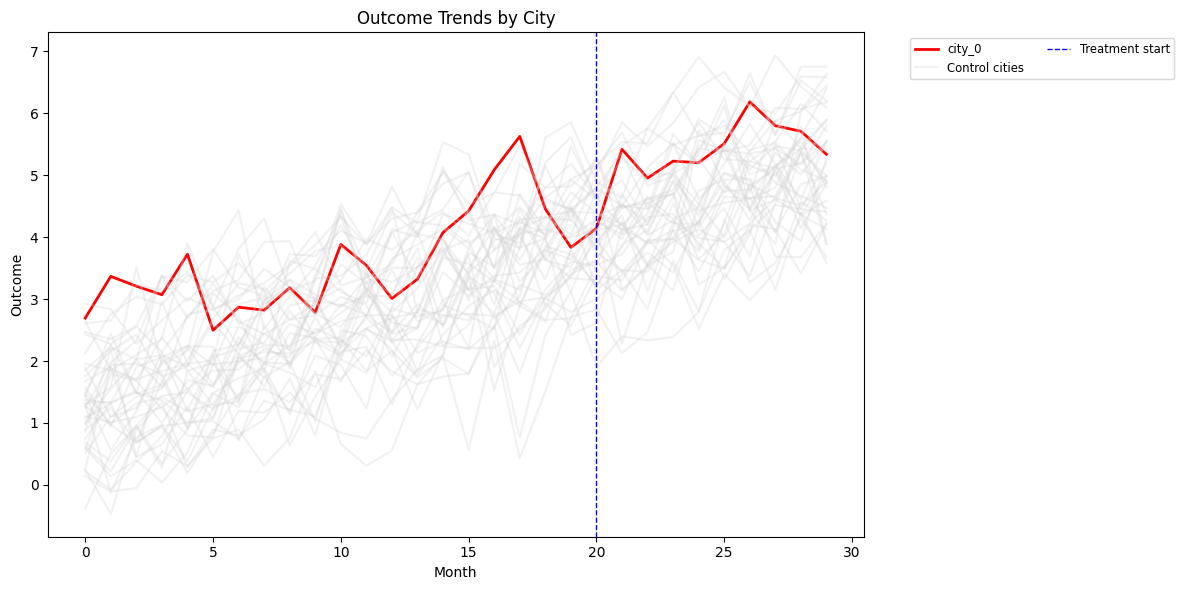

In [9]:
import matplotlib.pyplot as plt

# Plot outcome trends by city
plt.figure(figsize=(12, 6))
for city_name, group in df.groupby('city'):
    if city_name == 'city_0':  # Highlight the treated city
        plt.plot(group['month'], group['outcome'], label=city_name, color='red', linewidth=2)
    else:  # Make other cities more transparent or faded
        plt.plot(group['month'], group['outcome'], color='lightgray', alpha=0.3, label='Control cities' if city_name == 'city_1' else "")

plt.axvline(x=T0, color='blue', linestyle='--', linewidth=1, label='Treatment start')

plt.title('Outcome Trends by City')
plt.xlabel('Month')
plt.ylabel('Outcome')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

To fit a synthetic control model, I think the best way is to use R's `Synth` package .  There are a few synthetic control packages in Python, but in my experience the Python packages are not as reliable as R's `Synth`.

My R script to fit this model is saved in the scripts folder.

In [10]:
df.to_csv('../data/city_month.csv', index=False)